In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve
)

# Model persistence
import joblib

print("✓ All libraries imported successfully!")
print(f"Scikit-learn version: {joblib.__version__}")


✓ All libraries imported successfully!
Scikit-learn version: 1.3.2


In [3]:
# Load processed data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print("Dataset Loaded:")
print("="*70)
print(f"Train Shape: {train.shape}")
print(f"Test Shape:  {test.shape}")

# Separate features and target
X_train = train.drop('target_binary', axis=1)
y_train = train['target_binary']

X_test = test.drop('target_binary', axis=1)
y_test = test['target_binary']

print(f"\nFeatures: {X_train.shape[1]}")
print(f"Target Distribution (Train): {dict(y_train.value_counts())}")
print(f"Target Distribution (Test):  {dict(y_test.value_counts())}")

# Show first few rows
print("\n" + "="*70)
print("Sample Features:")
X_train.head(3)


Dataset Loaded:
Train Shape: (2004, 20)
Test Shape:  (502, 20)

Features: 19
Target Distribution (Train): {1: 1338, 0: 666}
Target Distribution (Test):  {1: 335, 0: 167}

Sample Features:


,hour,day_of_week,month,is_weekend,is_rush_hour,is_night,is_monsoon,weather_main,road_type,is_junction,is_urban,is_highway,Year,Number of Vehicles Involved,Number of Casualties,Number of Fatalities,Speed Limit (km/h),Driver Age,year
0,10.0,5.0,10.0,1,0,0,0,Fog,urban,0,1,0,2021,5,3,1,78,56,2025.0
1,21.0,5.0,10.0,1,0,0,0,Storm,highway,0,1,0,2019,1,9,0,108,44,2025.0
2,7.0,5.0,10.0,1,1,0,0,Rain,rural,0,1,0,2022,5,6,0,41,43,2025.0


In [4]:
# Automatically detect feature types
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Feature Types:")
print("="*70)
print(f"\nCategorical Features ({len(categorical_features)}):")
for i, feat in enumerate(categorical_features, 1):
    unique_count = X_train[feat].nunique()
    print(f"  {i}. {feat:20s} - {unique_count} unique values")

print(f"\nNumerical Features ({len(numerical_features)}):")
for i, feat in enumerate(numerical_features, 1):
    min_val = X_train[feat].min()
    max_val = X_train[feat].max()
    print(f"  {i}. {feat:20s} - Range: [{min_val}, {max_val}]")

print("\n" + "="*70)


Feature Types:

Categorical Features (2):
  1. weather_main         - 5 unique values
  2. road_type            - 3 unique values

Numerical Features (17):
  1. hour                 - Range: [0.0, 23.0]
  2. day_of_week          - Range: [5.0, 5.0]
  3. month                - Range: [10.0, 10.0]
  4. is_weekend           - Range: [1, 1]
  5. is_rush_hour         - Range: [0, 1]
  6. is_night             - Range: [0, 1]
  7. is_monsoon           - Range: [0, 0]
  8. is_junction          - Range: [0, 0]
  9. is_urban             - Range: [1, 1]
  10. is_highway           - Range: [0, 0]
  11. Year                 - Range: [2018, 2023]
  12. Number of Vehicles Involved - Range: [1, 5]
  13. Number of Casualties - Range: [0, 10]
  14. Number of Fatalities - Range: [0, 5]
  15. Speed Limit (km/h)   - Range: [30, 120]
  16. Driver Age           - Range: [18, 70]
  17. year                 - Range: [2025.0, 2025.0]



In [5]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing Pipeline Created:")
print("="*70)
print("Transformations:")
print("  1. StandardScaler  → Numerical features")
print("  2. OneHotEncoder   → Categorical features")
print("\n✓ Pipeline ready for training!")


Preprocessing Pipeline Created:
Transformations:
  1. StandardScaler  → Numerical features
  2. OneHotEncoder   → Categorical features

✓ Pipeline ready for training!


In [6]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        solver='lbfgs'
    ),
    
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        class_weight='balanced'
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    )
}

print("Models Defined:")
print("="*70)
for i, (name, _) in enumerate(models.items(), 1):
    print(f"{i}. {name}")

print("\n✓ 4 models ready for training!")


Models Defined:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

✓ 4 models ready for training!


In [7]:
import time

# Store results
results = {}
trained_pipelines = {}

print("Training Models...")
print("="*70)

for model_name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'training_time': training_time,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    trained_pipelines[model_name] = pipeline
    
    # Print results
    print(f"✓ Training completed in {training_time:.2f} seconds")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  PR-AUC:    {pr_auc:.4f}")

print("\n" + "="*70)
print("✓✓✓ ALL MODELS TRAINED! ✓✓✓")
print("="*70)


Training Models...

Training: Logistic Regression
✓ Training completed in 0.05 seconds
  Accuracy:  0.5239
  Precision: 0.6890
  Recall:    0.5224
  F1-Score:  0.5942
  ROC-AUC:   0.5335
  PR-AUC:    0.7035

Training: Decision Tree
✓ Training completed in 0.02 seconds
  Accuracy:  0.5498
  Precision: 0.7088
  Recall:    0.5522
  F1-Score:  0.6208
  ROC-AUC:   0.5606
  PR-AUC:    0.7007

Training: Random Forest
✓ Training completed in 0.79 seconds
  Accuracy:  0.6295
  Precision: 0.6795
  Recall:    0.8418
  F1-Score:  0.7520
  ROC-AUC:   0.5149
  PR-AUC:    0.6638

Training: XGBoost
✓ Training completed in 1.38 seconds
  Accuracy:  0.6375
  Precision: 0.6861
  Recall:    0.8418
  F1-Score:  0.7560
  ROC-AUC:   0.5029
  PR-AUC:    0.6487

✓✓✓ ALL MODELS TRAINED! ✓✓✓


In [8]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T

# Round for display
comparison_df_display = comparison_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc', 'training_time']].round(4)

print("Model Performance Comparison:")
print("="*70)
print(comparison_df_display.to_string())

# Identify best model (based on F1-score)
best_model_name = comparison_df['f1_score'].idxmax()
best_f1 = comparison_df.loc[best_model_name, 'f1_score']

print("\n" + "="*70)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print("="*70)


Model Performance Comparison:
                     accuracy precision    recall  f1_score   roc_auc    pr_auc training_time
Logistic Regression  0.523904  0.688976  0.522388  0.594228  0.533524   0.70347      0.049667
Decision Tree        0.549801  0.708812  0.552239  0.620805  0.560649  0.700736      0.024921
Random Forest        0.629482  0.679518  0.841791     0.752  0.514934  0.663809      0.791845
XGBoost               0.63745  0.686131  0.841791  0.756032  0.502887  0.648711         1.378

🏆 BEST MODEL: XGBoost
   F1-Score: 0.7560


✓ Plot saved: models/model_comparison.png


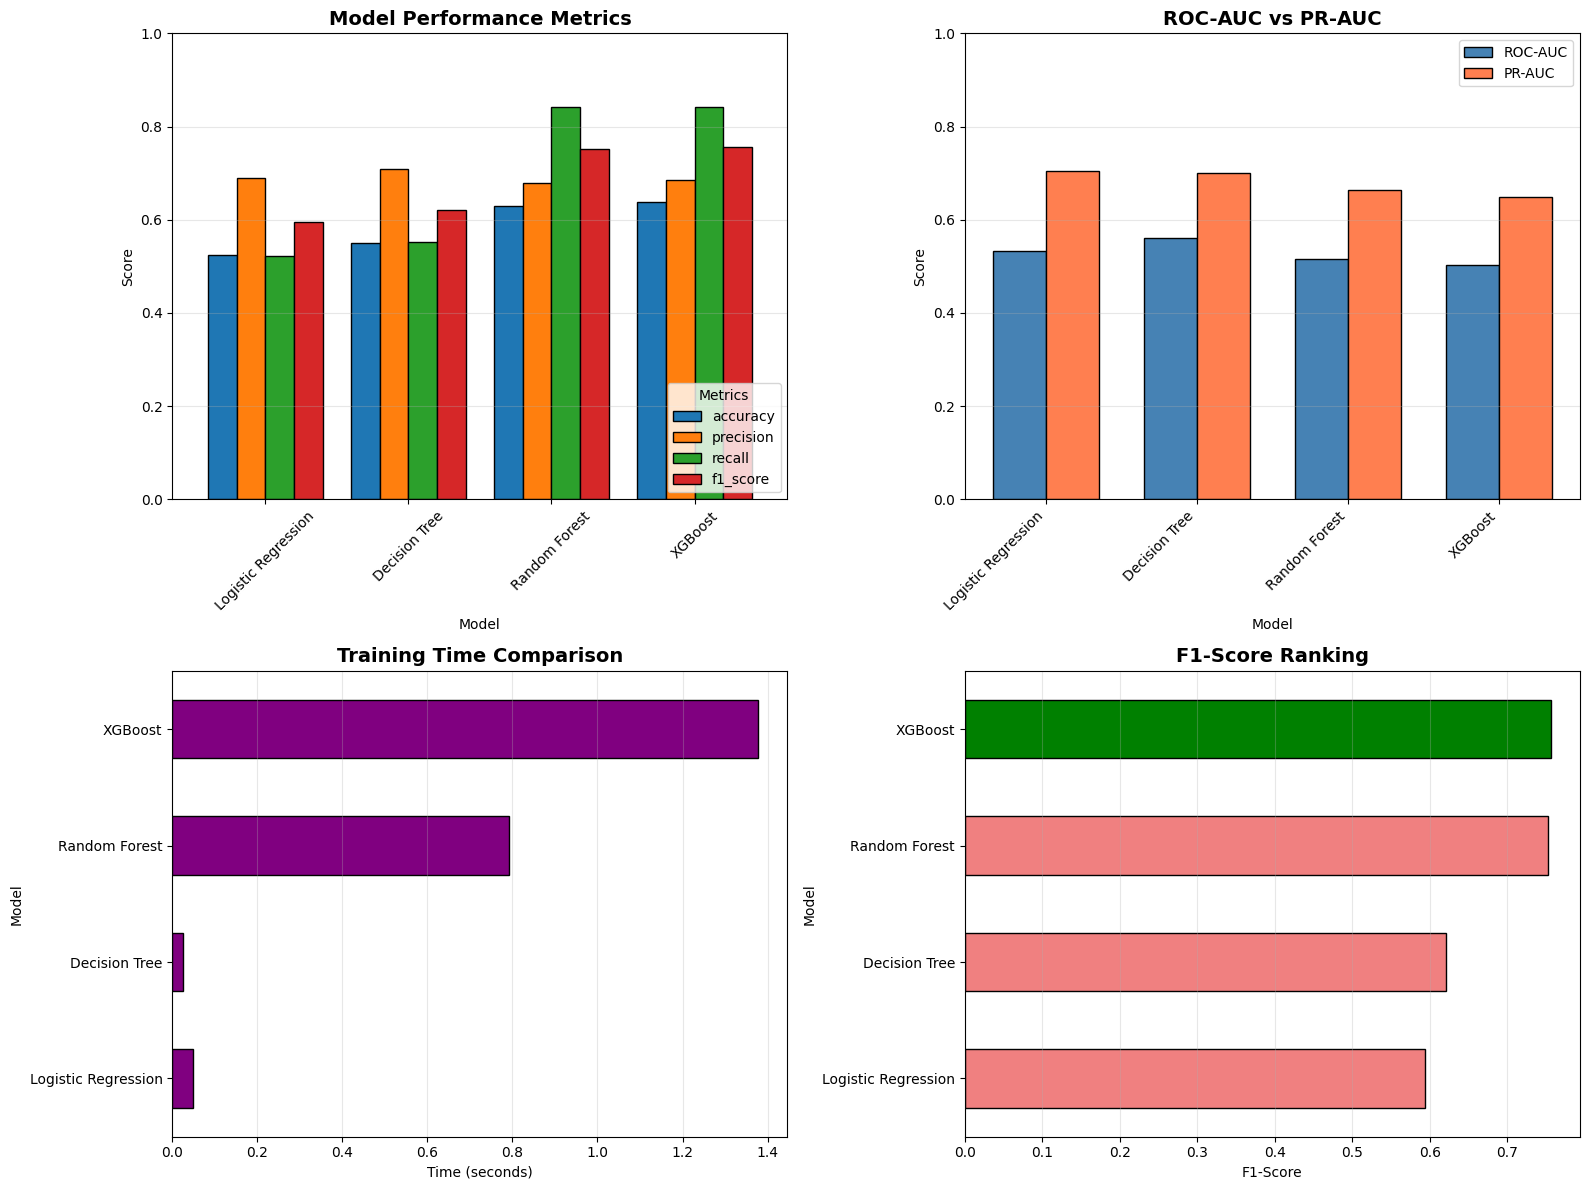

In [9]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
comparison_df[metrics_to_plot].plot(kind='bar', ax=axes[0,0], width=0.8, edgecolor='black')
axes[0,0].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_xlabel('Model')
axes[0,0].legend(title='Metrics', loc='lower right')
axes[0,0].set_ylim([0, 1])
axes[0,0].grid(axis='y', alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: ROC-AUC vs PR-AUC
x = np.arange(len(results))
width = 0.35
axes[0,1].bar(x - width/2, comparison_df['roc_auc'], width, label='ROC-AUC', color='steelblue', edgecolor='black')
axes[0,1].bar(x + width/2, comparison_df['pr_auc'], width, label='PR-AUC', color='coral', edgecolor='black')
axes[0,1].set_title('ROC-AUC vs PR-AUC', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Score')
axes[0,1].set_xlabel('Model')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(comparison_df.index, rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].set_ylim([0, 1])
axes[0,1].grid(axis='y', alpha=0.3)

# Plot 3: Training time comparison
comparison_df['training_time'].plot(kind='barh', ax=axes[1,0], color='purple', edgecolor='black')
axes[1,0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Time (seconds)')
axes[1,0].set_ylabel('Model')
axes[1,0].grid(axis='x', alpha=0.3)

# Plot 4: F1-Score ranking
comparison_df_sorted = comparison_df.sort_values('f1_score', ascending=True)
colors = ['lightcoral' if x != best_model_name else 'green' for x in comparison_df_sorted.index]
comparison_df_sorted['f1_score'].plot(kind='barh', ax=axes[1,1], color=colors, edgecolor='black')
axes[1,1].set_title('F1-Score Ranking', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('F1-Score')
axes[1,1].set_ylabel('Model')
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=120, bbox_inches='tight')
print("✓ Plot saved: models/model_comparison.png")
plt.show()


✓ Confusion matrix saved: models/confusion_matrix.png


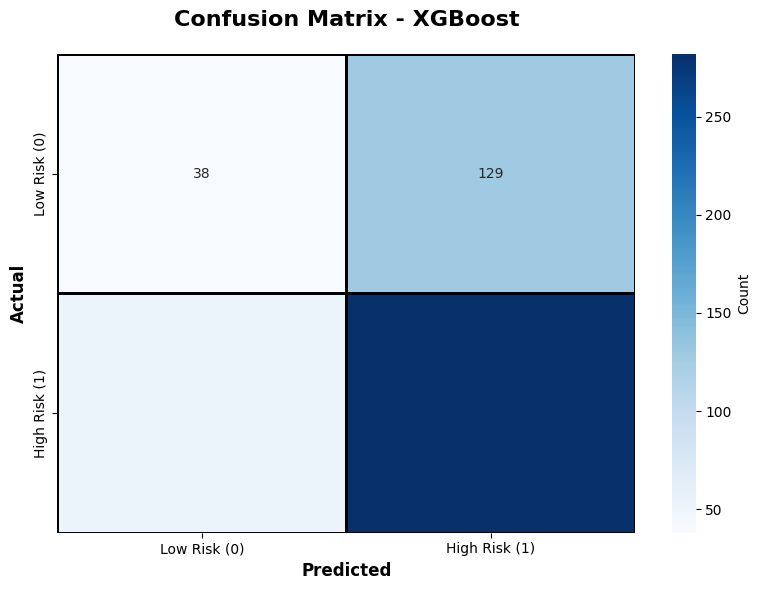


Confusion Matrix Breakdown:
True Negatives (TN):    38 - Correctly predicted Low Risk
False Positives (FP):  129 - Incorrectly predicted High Risk
False Negatives (FN):   53 - Incorrectly predicted Low Risk
True Positives (TP):   282 - Correctly predicted High Risk


In [10]:
# Get best model predictions
best_predictions = results[best_model_name]['predictions']

# Create confusion matrix
cm = confusion_matrix(y_test, best_predictions)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk (0)', 'High Risk (1)'],
            yticklabels=['Low Risk (0)', 'High Risk (1)'],
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black')

plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=120, bbox_inches='tight')
print("✓ Confusion matrix saved: models/confusion_matrix.png")
plt.show()

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print("="*70)
print(f"True Negatives (TN):  {cm[0,0]:4d} - Correctly predicted Low Risk")
print(f"False Positives (FP): {cm[0,1]:4d} - Incorrectly predicted High Risk")
print(f"False Negatives (FN): {cm[1,0]:4d} - Incorrectly predicted Low Risk")
print(f"True Positives (TP):  {cm[1,1]:4d} - Correctly predicted High Risk")
print("="*70)


In [11]:
# Detailed classification report
print("Detailed Classification Report:")
print("="*70)
print(f"Model: {best_model_name}\n")
print(classification_report(y_test, best_predictions, 
                          target_names=['Low Risk (0)', 'High Risk (1)'],
                          digits=4))
print("="*70)


Detailed Classification Report:
Model: XGBoost

               precision    recall  f1-score   support

 Low Risk (0)     0.4176    0.2275    0.2946       167
High Risk (1)     0.6861    0.8418    0.7560       335

     accuracy                         0.6375       502
    macro avg     0.5519    0.5347    0.5253       502
 weighted avg     0.5968    0.6375    0.6025       502



✓ ROC curves saved: models/roc_curves.png


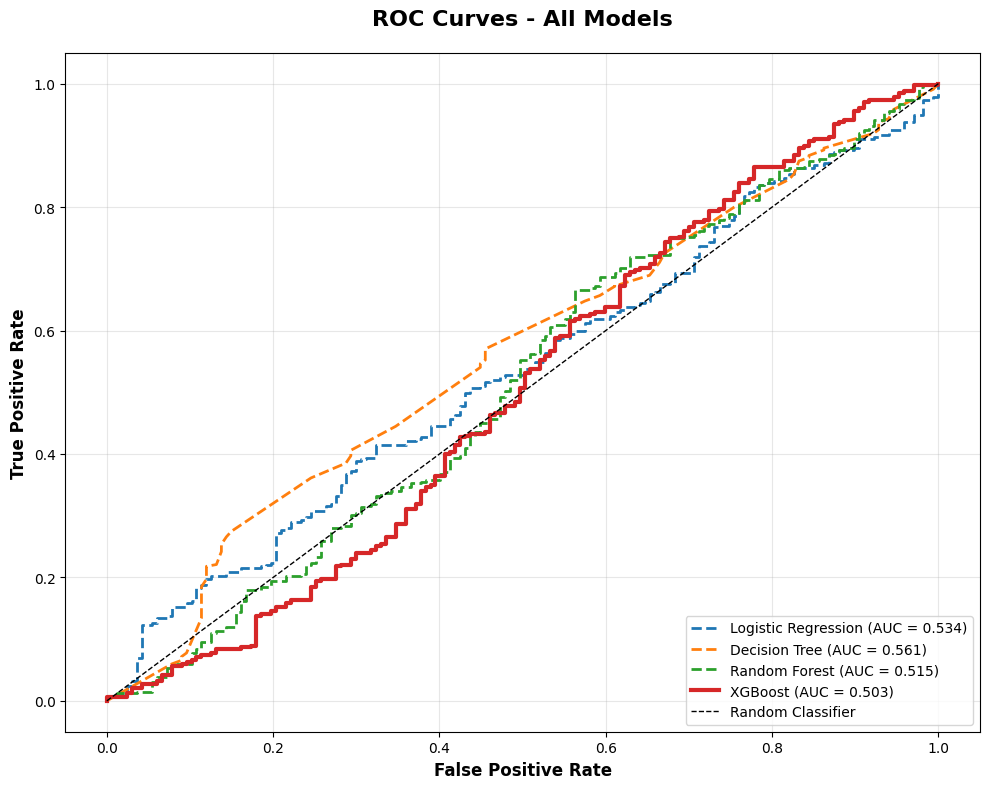

In [12]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model_name in results.keys():
    y_proba = results[model_name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = results[model_name]['roc_auc']
    
    linestyle = '-' if model_name == best_model_name else '--'
    linewidth = 3 if model_name == best_model_name else 2
    
    plt.plot(fpr, tpr, linestyle=linestyle, linewidth=linewidth,
             label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/roc_curves.png', dpi=120, bbox_inches='tight')
print("✓ ROC curves saved: models/roc_curves.png")
plt.show()


✓ PR curves saved: models/precision_recall_curves.png


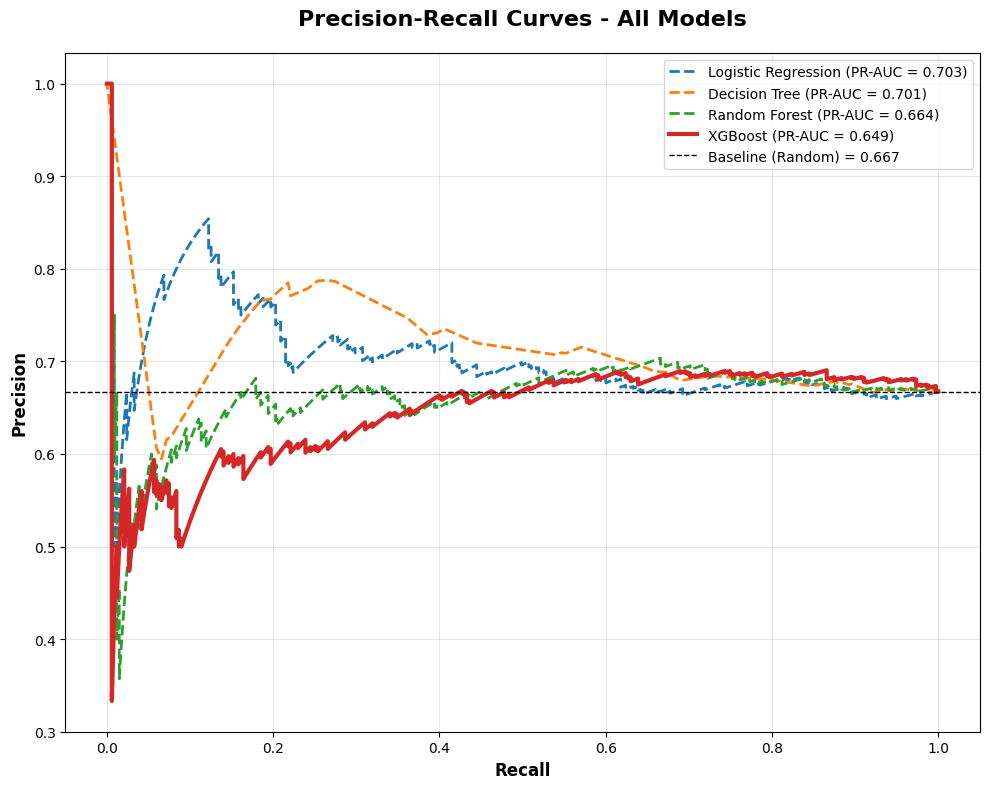

In [13]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))

for model_name in results.keys():
    y_proba = results[model_name]['probabilities']
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = results[model_name]['pr_auc']
    
    linestyle = '-' if model_name == best_model_name else '--'
    linewidth = 3 if model_name == best_model_name else 2
    
    plt.plot(recall, precision, linestyle=linestyle, linewidth=linewidth,
             label=f'{model_name} (PR-AUC = {pr_auc:.3f})')

# Baseline (random classifier)
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', linewidth=1, 
            label=f'Baseline (Random) = {baseline:.3f}')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - All Models', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/precision_recall_curves.png', dpi=120, bbox_inches='tight')
print("✓ PR curves saved: models/precision_recall_curves.png")
plt.show()


✓ Feature importance saved: models/feature_importance.png


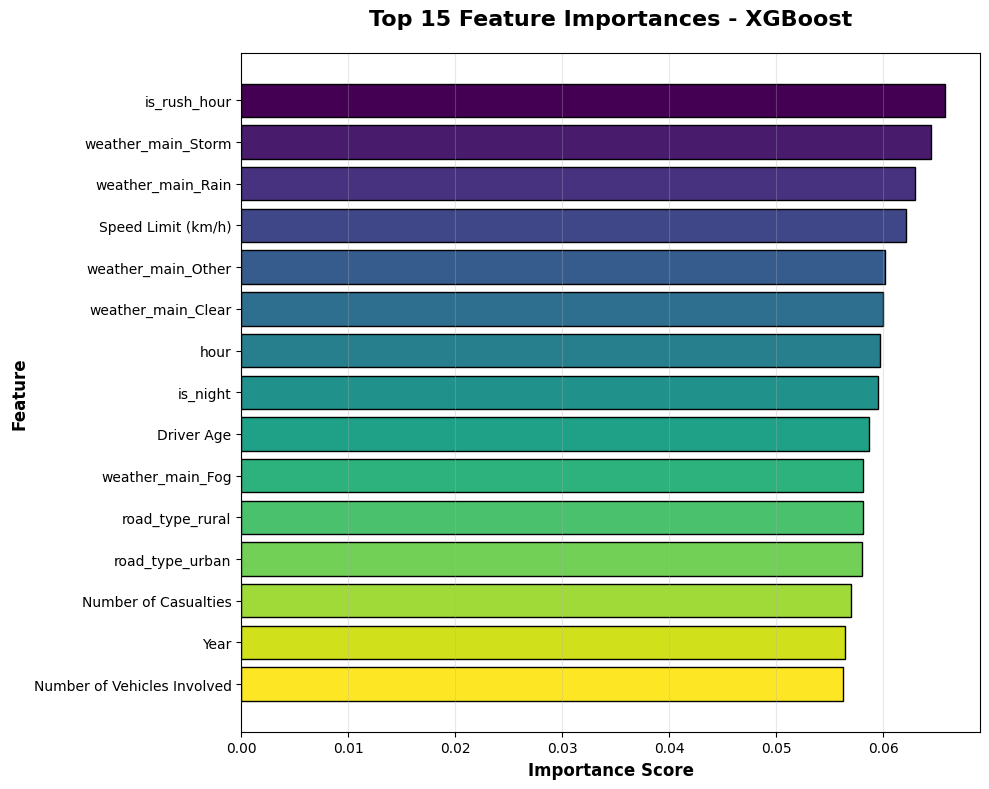


Top 10 Most Important Features:
           Feature  Importance
      is_rush_hour    0.065761
weather_main_Storm    0.064498
 weather_main_Rain    0.062952
Speed Limit (km/h)    0.062172
weather_main_Other    0.060197
weather_main_Clear    0.059965
              hour    0.059748
          is_night    0.059493
        Driver Age    0.058669
  weather_main_Fog    0.058151


In [14]:
# Extract feature importance for best model if it's tree-based
best_pipeline = trained_pipelines[best_model_name]
best_classifier = best_pipeline.named_steps['classifier']

if hasattr(best_classifier, 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = []
    
    # Numerical features keep their names
    feature_names.extend(numerical_features)
    
    # Categorical features get one-hot encoded names
    if len(categorical_features) > 0:
        encoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_feature_names = encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    
    # Get importances
    importances = best_classifier.feature_importances_
    
    # Create dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors, edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../models/feature_importance.png', dpi=120, bbox_inches='tight')
    print("✓ Feature importance saved: models/feature_importance.png")
    plt.show()
    
    # Print top 10
    print("\nTop 10 Most Important Features:")
    print("="*70)
    print(importance_df.head(10).to_string(index=False))
    
else:
    print(f"⚠ {best_model_name} does not have feature_importances_ attribute")
    print("  (Feature importance only available for tree-based models)")


In [15]:
# Save the best model pipeline
best_pipeline = trained_pipelines[best_model_name]

model_path = '../models/model.pkl'
joblib.dump(best_pipeline, model_path)

print("Model Saved!")
print("="*70)
print(f"✓ Model: {best_model_name}")
print(f"✓ Path: {model_path}")
print(f"✓ F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"✓ ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print("="*70)

# Verify saved model
loaded_model = joblib.load(model_path)
test_prediction = loaded_model.predict(X_test[:5])
print(f"\n✓ Model verification: Loaded and tested successfully")
print(f"  Sample predictions: {test_prediction}")


Model Saved!
✓ Model: XGBoost
✓ Path: ../models/model.pkl
✓ F1-Score: 0.7560
✓ ROC-AUC: 0.5029

✓ Model verification: Loaded and tested successfully
  Sample predictions: [1 0 1 1 1]


In [17]:
# Helper function to convert numpy types to native Python types
def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Create comprehensive metadata
metadata = {
    'best_model': best_model_name,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'train_size': int(len(X_train)),
        'test_size': int(len(X_test)),
        'features': X_train.columns.tolist(),
        'categorical_features': categorical_features,
        'numerical_features': numerical_features,
        'target_distribution_train': convert_numpy_types(dict(y_train.value_counts())),
        'target_distribution_test': convert_numpy_types(dict(y_test.value_counts()))
    },
    'performance': {
        model_name: {
            'accuracy': float(results[model_name]['accuracy']),
            'precision': float(results[model_name]['precision']),
            'recall': float(results[model_name]['recall']),
            'f1_score': float(results[model_name]['f1_score']),
            'roc_auc': float(results[model_name]['roc_auc']),
            'pr_auc': float(results[model_name]['pr_auc']),
            'training_time': float(results[model_name]['training_time'])
        }
        for model_name in results.keys()
    },
    'best_model_metrics': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'precision': float(results[best_model_name]['precision']),
        'recall': float(results[best_model_name]['recall']),
        'f1_score': float(results[best_model_name]['f1_score']),
        'roc_auc': float(results[best_model_name]['roc_auc']),
        'pr_auc': float(results[best_model_name]['pr_auc'])
    }
}

# Save metadata
with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata Saved!")
print("="*70)
print(json.dumps(metadata['best_model_metrics'], indent=2))
print("\n✓ File: models/model_metadata.json")
print("="*70)


Metadata Saved!
{
  "accuracy": 0.6374501992031872,
  "precision": 0.6861313868613139,
  "recall": 0.8417910447761194,
  "f1_score": 0.7560321715817695,
  "roc_auc": 0.5028867637858612,
  "pr_auc": 0.6487111348022165
}

✓ File: models/model_metadata.json


In [18]:
print("\n" + "="*70)
print("TRAINING SUMMARY REPORT".center(70))
print("="*70)

print(f"\n📊 Dataset Information:")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Total features: {X_train.shape[1]}")
print(f"   • Categorical: {len(categorical_features)}")
print(f"   • Numerical: {len(numerical_features)}")

print(f"\n🤖 Models Trained: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Accuracy:  {results[best_model_name]['accuracy']:.4f}")
print(f"   • Precision: {results[best_model_name]['precision']:.4f}")
print(f"   • Recall:    {results[best_model_name]['recall']:.4f}")
print(f"   • F1-Score:  {results[best_model_name]['f1_score']:.4f}")
print(f"   • ROC-AUC:   {results[best_model_name]['roc_auc']:.4f}")
print(f"   • PR-AUC:    {results[best_model_name]['pr_auc']:.4f}")

print(f"\n💾 Files Saved:")
print(f"   • models/model.pkl")
print(f"   • models/model_metadata.json")
print(f"   • models/model_comparison.png")
print(f"   • models/confusion_matrix.png")
print(f"   • models/roc_curves.png")
print(f"   • models/precision_recall_curves.png")
if hasattr(best_classifier, 'feature_importances_'):
    print(f"   • models/feature_importance.png")

print("\n" + "="*70)
print("✓✓✓ MODEL TRAINING COMPLETE! ✓✓✓".center(70))
print("="*70)


                       TRAINING SUMMARY REPORT                        

📊 Dataset Information:
   • Training samples: 2,004
   • Test samples: 502
   • Total features: 19
   • Categorical: 2
   • Numerical: 17

🤖 Models Trained: 4
   1. Logistic Regression
   2. Decision Tree
   3. Random Forest
   4. XGBoost

🏆 Best Model: XGBoost
   • Accuracy:  0.6375
   • Precision: 0.6861
   • Recall:    0.8418
   • F1-Score:  0.7560
   • ROC-AUC:   0.5029
   • PR-AUC:    0.6487

💾 Files Saved:
   • models/model.pkl
   • models/model_metadata.json
   • models/model_comparison.png
   • models/confusion_matrix.png
   • models/roc_curves.png
   • models/precision_recall_curves.png
   • models/feature_importance.png

                   ✓✓✓ MODEL TRAINING COMPLETE! ✓✓✓                   
